# Imports

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.cluster.hierarchy import linkage

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocessing

In [2]:
# Read dataset
df_raw_input = pd.read_excel("Assessment Part 2 dataset.xlsx", header=0)

# Drop first column
df = df_raw_input.drop(columns="a_a")

print(f"Loaded dataset with rows: {len(df)}")

# Replace invalid values with nan
df["gender"] = df["gender"].replace(3, np.nan) # replace 'Other' with nan
df["gender"] = df["gender"].replace(4, np.nan) # replace 'Prefer not to respond' with nan
df["income"] = df["income"].replace(9, np.nan) # replace 'Prefer not to respond' with nan

print("\nMissing values:")
print(pd.DataFrame({
    'Column': df.columns,
    'NaN (count)': df.isna().sum().values,
    'NaN (%)': (df.isna().sum() / len(df) * 100).round(2).values
})[df.isna().sum().values > 0])

# Drop rows with missing values
df = df.dropna(how="any", axis=0)

print(f"\nDropped rows with missing values.\nRemaining number of rows: {len(df)}")

Loaded dataset with rows: 1324

Missing values:
    Column  NaN (count)  NaN (%)
24  gender            6     0.45
26  income           32     2.42

Dropped rows with missing values.
Remaining number of rows: 1289


# Scaling
All the variables must have the same scale. Z-score standardization was used.

In [3]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.describe()

,health_satisfaction,body_ap_satisfaction,health_conciousness_1,health_conciousness_2,CB1_reduce_cost,CB1_convenience,CB1_environment,CB1_pay_more_eco,CB1_clear_benefits,CB1_user_experience,...,criterion_maintenance,criterion_brand_name,criterion_ease_of_use,criterion_support,criterion_reviews,criterion_referrals,criterion_past_exp,gender,age_group,income
count,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03,1289.000000,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03,...,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03,1.289000e+03
mean,2.315190e-16,8.819770e-17,-2.204943e-16,-1.322966e-16,0.000000,-2.315190e-16,-6.614828e-17,-6.614828e-17,-2.204943e-17,3.417661e-16,...,-1.212718e-16,-2.204943e-16,2.039572e-16,-1.102471e-17,2.756178e-16,-1.653707e-16,-2.094695e-16,-3.445223e-17,-8.819770e-17,-2.204943e-16
std,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00,1.000388,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00,...,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00,1.000388e+00
min,-2.292437e+00,-1.861432e+00,-3.174197e+00,-3.712242e+00,-2.536112,-2.401182e+00,-2.380199e+00,-1.887372e+00,-4.053124e+00,-3.263935e+00,...,-4.510637e+00,-1.640446e+00,-3.730803e+00,-2.412094e+00,-2.922431e+00,-2.330042e+00,-2.555561e+00,-1.064944e+00,-1.921695e+00,-2.097604e+00
25%,-1.030446e+00,-7.009069e-01,-3.194683e-01,-5.104487e-01,-0.717280,-5.169753e-01,-5.086598e-01,-8.003199e-01,-6.467821e-01,-9.543948e-01,...,-1.383922e-01,-5.775985e-01,-5.830333e-01,-5.874525e-01,-3.195541e-01,-4.718707e-01,-6.174644e-01,-1.064944e+00,-1.007312e+00,-1.080942e+00
50%,2.315444e-01,-1.206442e-01,3.942139e-01,2.899995e-01,-0.111002,1.110936e-01,1.151865e-01,2.867321e-01,2.048033e-01,-1.845482e-01,...,7.360567e-01,-4.617490e-02,2.039090e-01,2.076137e-02,3.311651e-01,1.475197e-01,2.856775e-02,9.390164e-01,-9.292804e-02,-6.428077e-02
75%,8.625397e-01,1.039881e+00,1.107896e+00,1.090448e+00,1.101553,7.391626e-01,7.390329e-01,8.302581e-01,1.056389e+00,5.852984e-01,...,7.360567e-01,4.852487e-01,9.908514e-01,6.289753e-01,9.818843e-01,7.669100e-01,6.745999e-01,9.390164e-01,8.214555e-01,9.523807e-01
max,1.493535e+00,1.620144e+00,1.107896e+00,1.090448e+00,1.101553,1.367231e+00,1.362879e+00,1.373784e+00,1.056389e+00,1.355145e+00,...,7.360567e-01,1.548096e+00,9.908514e-01,1.237189e+00,9.818843e-01,1.386300e+00,1.320632e+00,9.390164e-01,1.735839e+00,1.460711e+00


# Calculate VIF

In [4]:
# Calculate VIF for each feature
df_cleaned = df_scaled.copy()
vif_data = pd.DataFrame()
vif_data["feature"] = df_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(df_cleaned.values, i) for i in range(df_cleaned.shape[1])]

# Display VIF
print(vif_data)

                  feature       VIF
0     health_satisfaction  2.202991
1    body_ap_satisfaction  2.296977
2   health_conciousness_1  1.720667
3   health_conciousness_2  1.872424
4         CB1_reduce_cost  1.487451
5         CB1_convenience  1.361799
6         CB1_environment  2.852316
7        CB1_pay_more_eco  2.953200
8      CB1_clear_benefits  1.986343
9     CB1_user_experience  2.176443
10      CB1_money_for_WMS  1.929380
11      functional_health  2.239984
12   functional_effective  2.244172
13        criterion_price  1.433210
14      criterion_quality  2.213528
15  criterion_weight_loss  2.074980
16        criterion_speed  1.826259
17  criterion_maintenance  2.358126
18   criterion_brand_name  1.637435
19  criterion_ease_of_use  1.836533
20      criterion_support  1.885066
21      criterion_reviews  1.971630
22    criterion_referrals  1.727907
23     criterion_past_exp  1.712461
24                 gender  1.076598
25              age_group  1.314433
26                 income  1

# Correlation matrix

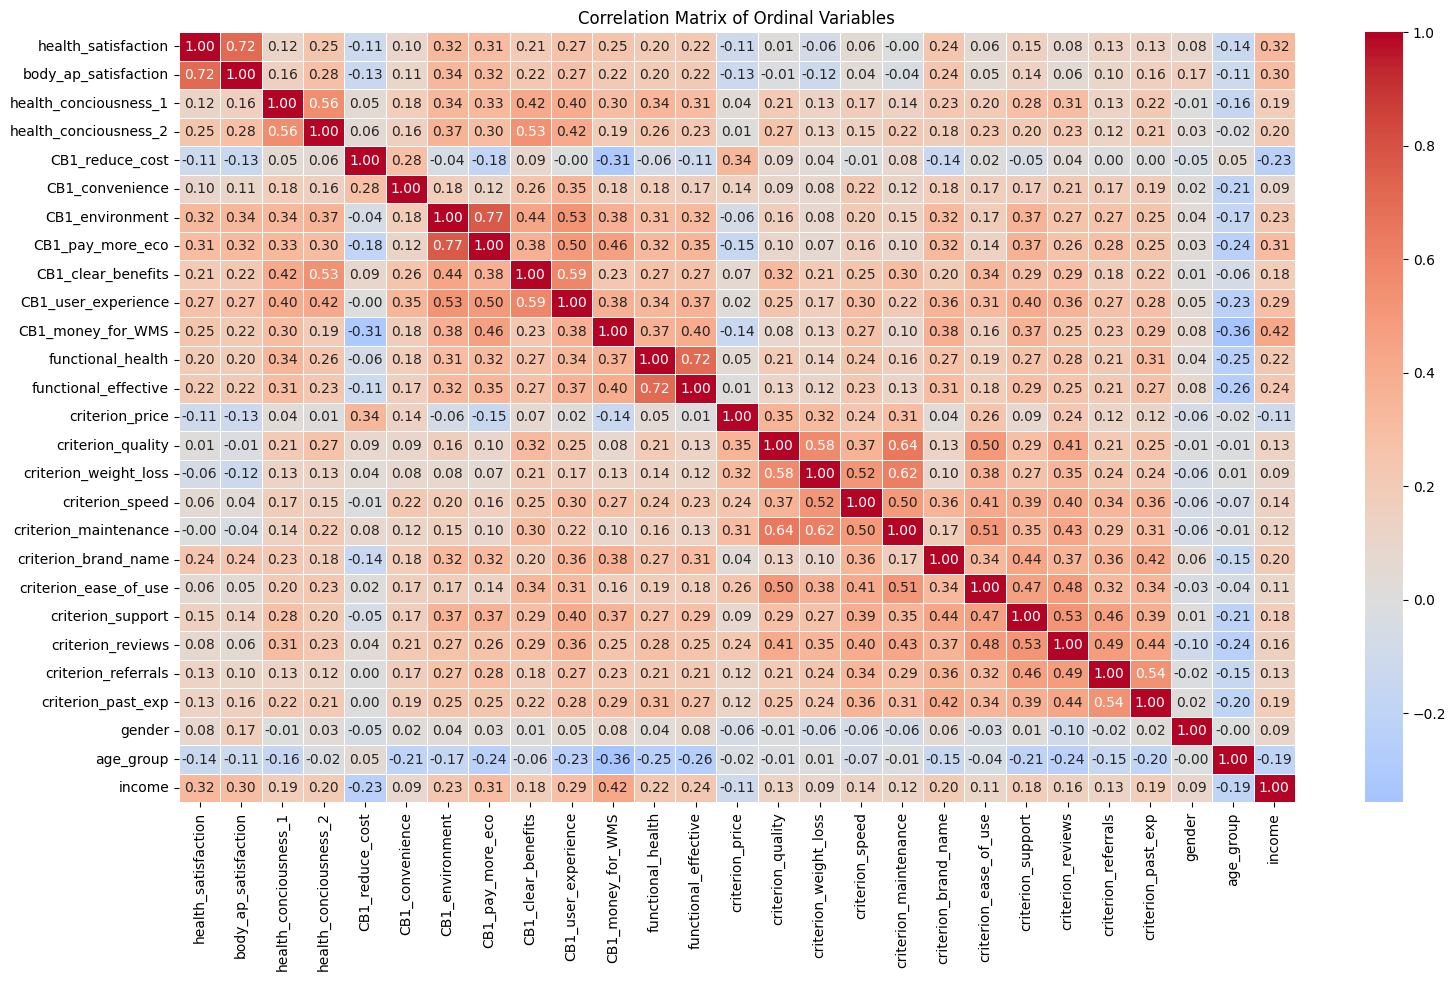

In [5]:
# Compute the correlation matrix
correlation_matrix = df_cleaned.corr(method='pearson')

# Set up the figure size
plt.figure(figsize=(18, 10))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0)

# Add title
plt.title('Correlation Matrix of Ordinal Variables')

# Show the plot
plt.show()

# Determine number of clusters (using linkage)

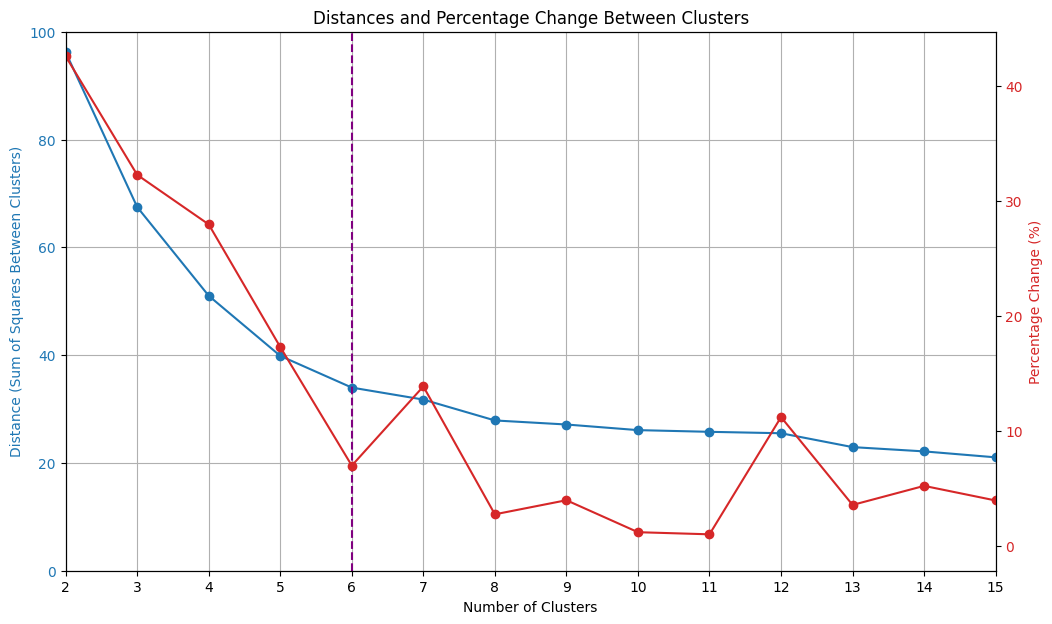

In [6]:
# Compute the linkage matrix using Ward's method
linkage_matrix = linkage(df_cleaned, method='ward')

# Calculate the distances between merged clusters
cluster_distances = linkage_matrix[:, 2]

# Calculate the percentage difference in distances between successive merges
cluster_distances_change = np.diff(cluster_distances) / cluster_distances[:-1] * 100  # % difference between successive distances

# Prepare data for the plot
cluster_distance_data = pd.DataFrame({"Clusters": range(2, len(cluster_distances) + 1), "Distance": reversed(cluster_distances[1:]), "Chnage (%)": reversed(cluster_distances_change)})

# Create a figure
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot the distances on the primary y-axis
ax1.plot(cluster_distance_data["Clusters"], cluster_distance_data["Distance"], marker='o', color='tab:blue')
ax1.set_xlim(2, 15)
ax1.set_ylim(0, 100)
ax1.set_xticks(range(2, 16, 1))
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Distance (Sum of Squares Between Clusters)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a secondary y-axis for the percentage change
ax2 = ax1.twinx()
ax2.plot(cluster_distance_data["Clusters"], cluster_distance_data["Chnage (%)"], marker='o', color='tab:red')
ax2.set_ylabel('Percentage Change (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add line to show the selected number of clusters
ax1.vlines(6, 0, 100, color='purple', linestyles='dashed')

# Add titles and show the plot
plt.title('Distances and Percentage Change Between Clusters')
plt.show()


# Assigning clusters (K-means)

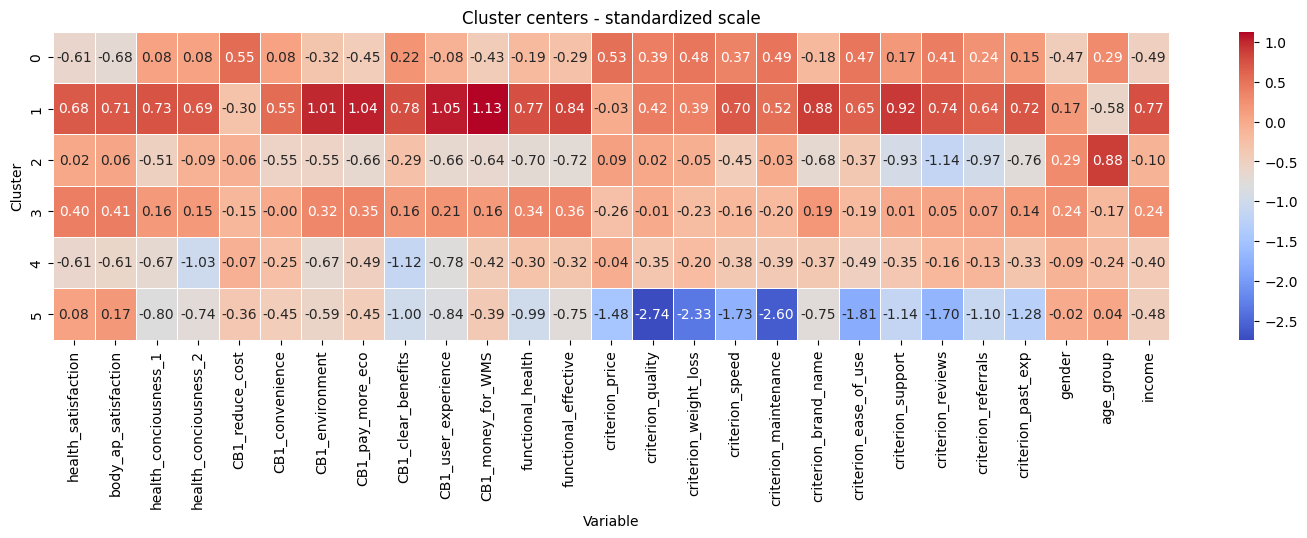

In [7]:
# Define the number of clusters
n_clusters = 6

# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=1)

df_clusters = df_cleaned.copy(deep=True)

# Fit the KMeans model to the cleaned data
kmeans.fit(df_clusters)

# Get the cluster labels (which cluster each sample belongs to)
df_clusters['Cluster'] = kmeans.labels_

# Calculate the mean of each variable for each cluster
cluster_means = df_clusters.groupby('Cluster').mean()

# Plot the heatmap of cluster means
plt.figure(figsize=(18, 4))
sns.heatmap(pd.DataFrame(kmeans.cluster_centers_, columns=df_cleaned.columns), annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title("Cluster centers - standardized scale")
plt.ylabel("Cluster")
plt.xlabel("Variable")
plt.show()


# Rescale data back to original with assigned clusters

In [8]:
# Inverse transform the cluster centers to original scale
cluster_centers_original_scale = scaler.inverse_transform(kmeans.cluster_centers_)

df_clusters_original = df.copy(deep=True)
df_clusters_original["Cluster"] = df_clusters["Cluster"]

# Print the cluster centers in their original scale as a DataFrame with column names
df_cluster_centers_original = pd.DataFrame(cluster_centers_original_scale, columns=df_cleaned.columns)
df_cluster_centers_original = df_cluster_centers_original.transpose()
df_cluster_centers_original = df_cluster_centers_original.round(3)

# Display the cluster centers as a DataFrame
df_cluster_centers_original

,0,1,2,3,4,5
health_satisfaction,3.662,5.714,4.661,5.270,3.670,4.762
body_ap_satisfaction,3.029,5.429,4.306,4.912,3.165,4.508
health_conciousness_1,5.556,6.476,4.739,5.668,4.505,4.333
health_conciousness_2,5.740,6.505,5.522,5.825,4.356,4.714
CB1_reduce_cost,6.090,4.685,5.078,4.931,5.074,4.587
CB1_convenience,4.952,5.696,3.944,4.818,4.431,4.111
CB1_environment,4.302,6.432,3.928,5.325,3.739,3.873
CB1_pay_more_eco,3.643,6.385,3.250,5.120,3.569,3.651
CB1_clear_benefits,6.013,6.678,5.422,5.953,4.441,4.587
CB1_user_experience,5.138,6.601,4.378,5.515,4.223,4.143


# Summary statistics of clusters

In [9]:
# Print the count of members in each cluster
clusters_summary = pd.DataFrame({"Cluster": range(n_clusters), "Count": list(df_clusters['Cluster'].value_counts())})
clusters_summary["%"] = clusters_summary["Cluster"] / len(df_clusters) * 100

print(clusters_summary)

df_cluster_summary = df_clusters_original.copy(deep=True)
df_cluster_summary["income"] = df_clusters_original["income"].map({
    1: 5000,
    2: 15000,
    3: 25000,
    4: 35000,
    5: 45000,
    6: 60000,
    7: 85000,
    8: 130000
})

df_cluster_summary["age_group"] = df_clusters_original["age_group"].map({
    1: 20, 2: 29.5, 3: 42, 4: 57, 5: 75
})

df_cluster_summary = df_cluster_summary[["Cluster", "age_group", "income"]].groupby(["Cluster"]).agg({
    "Cluster": "count",
    "age_group": "mean",
    "income": "mean"
})

df_cluster_summary["Count %"] = df_cluster_summary["Cluster"] / sum(df_cluster_summary["Cluster"]) * 100
df_cluster_summary = df_cluster_summary[["Cluster", "Count %", "age_group", "income"]]

print(df_cluster_summary)

   Cluster  Count         %
0        0    311  0.000000
1        1    274  0.077580
2        2    273  0.155159
3        3    188  0.232739
4        4    180  0.310318
5        5     63  0.387898
         Cluster    Count %  age_group        income
Cluster                                             
0            311  24.127230  49.371383  40289.389068
1            273  21.179209  35.657509  89212.454212
2            180  13.964313  59.108333  52055.555556
3            274  21.256788  42.215328  63248.175182
4            188  14.584950  41.231383  45026.595745
5             63   4.887510  46.817460  41428.571429


# Cluster centers (plot)

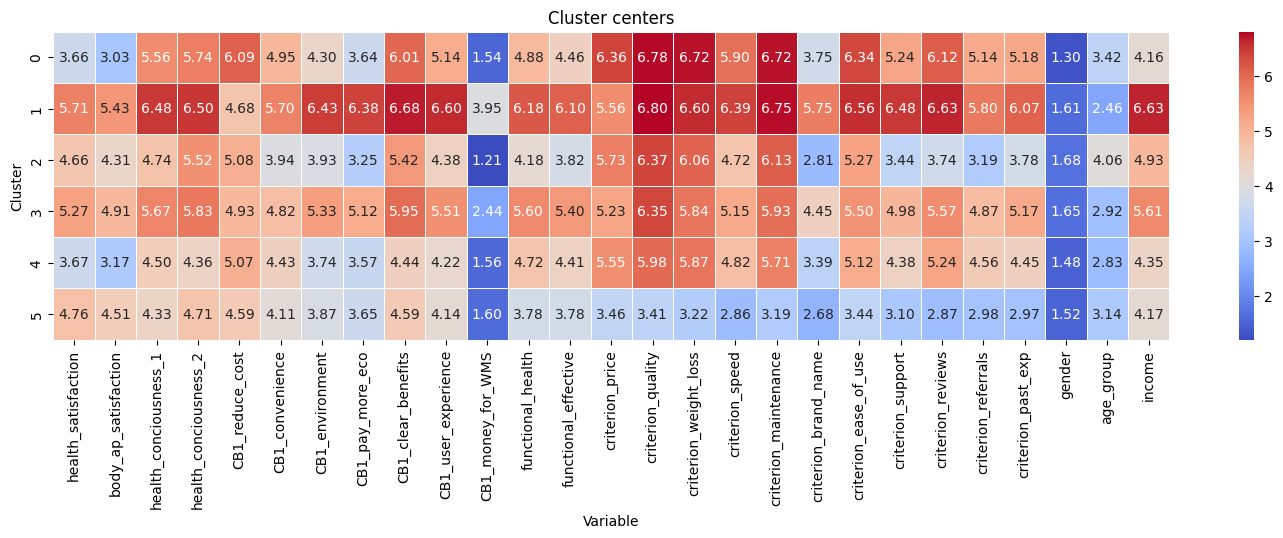

In [10]:
# Plot the heatmap of cluster means
plt.figure(figsize=(18, 4))
sns.heatmap(df_cluster_centers_original.transpose(), annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title("Cluster centers")
plt.ylabel("Cluster")
plt.xlabel("Variable")
plt.show()

# Chi-Square test
Test if clusters are significantly different

In [11]:
# Run Chi-Square test for each variable
results = {}
for col in df_clusters_original.columns.to_list():
    if col == 'Cluster':
        continue
    contingency_table = pd.crosstab(df_clusters_original[col], df_clusters_original["Cluster"])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    results[col] = {'Chi2': chi2, 'p-value': p}

# Convert results to a DataFrame
chi_square_results = pd.DataFrame(results).T
chi_square_results["H0"] = chi_square_results["p-value"] < 0.05
chi_square_results["Result"] = None
chi_square_results.loc[chi_square_results["H0"], "Result"] = "Significantly different"
chi_square_results.loc[~chi_square_results["H0"], "Result"] = "No significant difference"

# Display results
chi_square_results

,Chi2,p-value,H0,Result
health_satisfaction,477.908312,4.032979e-82,True,Significantly different
body_ap_satisfaction,532.209648,2.923144e-93,True,Significantly different
health_conciousness_1,495.410040,1.054174e-85,True,Significantly different
health_conciousness_2,492.672145,3.836070e-85,True,Significantly different
CB1_reduce_cost,258.276666,3.799131e-38,True,Significantly different
CB1_convenience,294.195438,3.676587e-45,True,Significantly different
CB1_environment,732.903816,6.678153e-135,True,Significantly different
CB1_pay_more_eco,764.821319,1.420122e-141,True,Significantly different
CB1_clear_benefits,663.470145,1.988961e-120,True,Significantly different
CB1_user_experience,790.487521,6.013655e-147,True,Significantly different


## Visualize using PCA

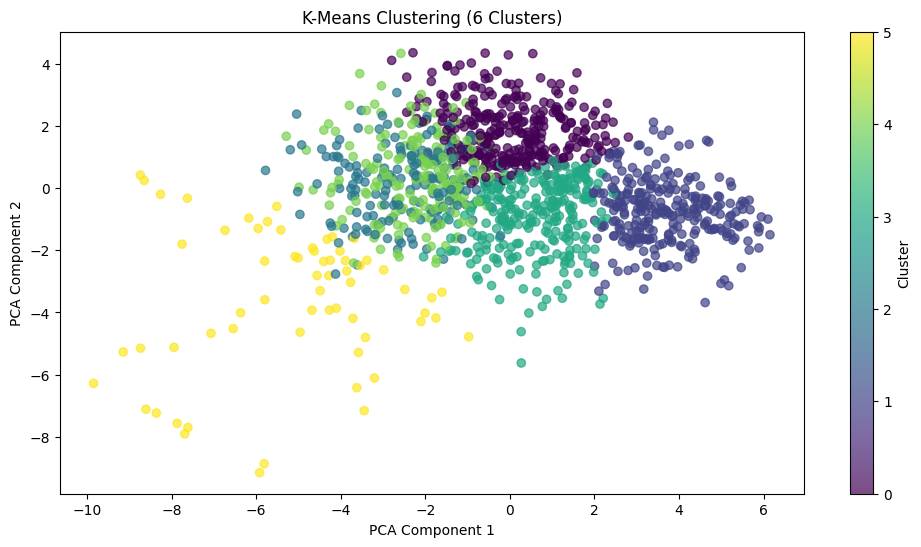

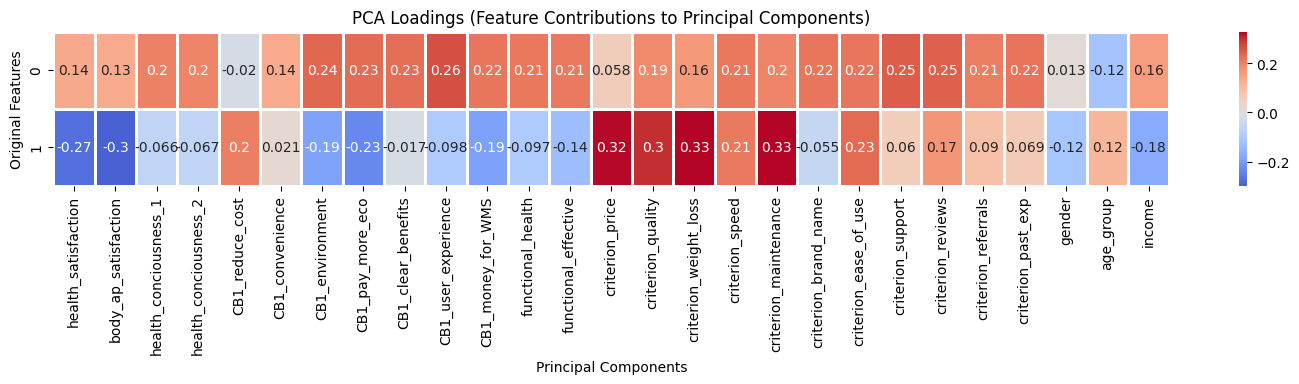

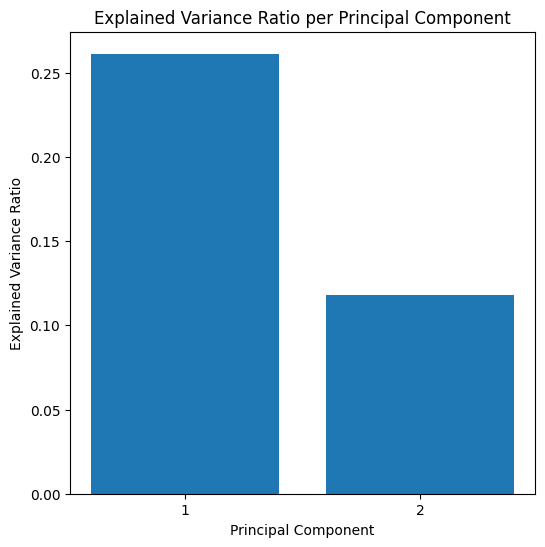

In [ ]:
# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_clusters.drop(columns=['Cluster']))

# Plot the clusters
plt.figure(figsize=(12, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_clusters['Cluster'], cmap='viridis', alpha=0.7)
plt.title(f'K-Means Clustering ({n_clusters} Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Get the PCA components (loadings)
components = pca.components_

# Create a DataFrame of the loadings (features x components)
pca_loadings = pd.DataFrame(components, columns=df_clusters.drop(columns=['Cluster']).columns)

# Plot the PCA loadings
plt.figure(figsize=(18, 2))
sns.heatmap(pca_loadings, annot=True, cmap='coolwarm', center=0, linewidths=1)
plt.title('PCA Loadings (Feature Contributions to Principal Components)')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

# Plot the explained variance ratio for each component
plt.figure(figsize=(6, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

# Dataframe format for export
Preprade data so it can be exported to Excel for additional analysis

In [13]:
pd.concat([df_clusters_original["Cluster"], df_raw_input], axis=1, join="outer", ignore_index=False, sort=True)

,Cluster,a_a,health_satisfaction,body_ap_satisfaction,health_conciousness_1,health_conciousness_2,CB1_reduce_cost,CB1_convenience,CB1_environment,CB1_pay_more_eco,...,criterion_maintenance,criterion_brand_name,criterion_ease_of_use,criterion_support,criterion_reviews,criterion_referrals,criterion_past_exp,gender,age_group,income
0,5.0,1,4,5,4,5,6,4,5,4,...,4,1,4,4,4,4,4,1,4,3
1,NaN,2,4,4,5,6,6,5,6,5,...,5,4,6,4,7,3,5,1,2,9
2,2.0,3,4,4,5,7,5,7,4,4,...,6,4,6,1,1,1,6,2,5,8
3,3.0,4,7,6,6,7,4,5,6,7,...,7,4,5,3,3,4,4,2,3,8
4,4.0,5,3,4,5,6,6,4,5,5,...,6,5,5,5,5,4,5,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,2.0,1320,6,6,5,6,7,5,4,5,...,7,1,4,4,5,1,1,2,3,5
1320,0.0,1321,5,1,6,6,5,2,7,7,...,7,4,6,6,7,5,6,1,4,3
1321,3.0,1322,4,3,7,7,4,7,7,7,...,6,5,7,5,7,5,7,1,3,7
1322,1.0,1323,7,7,7,7,6,5,7,7,...,6,1,6,6,5,5,6,1,2,8
